# Music Recommender System Based on Content filtering and Collaborative filering

1. Application(input: new user favourite songs, output: songs, play songs)
2. Content: Lyrics, Music Type, Artists
3. Collabrtive: userid, playcounts(algorithm)

In [2]:
# import libraries
import pandas as pd
from tswift import Song
from tqdm import tqdm
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import math
from statistics import mean
import matplotlib.pyplot as plt
import sys
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
from sklearn.preprocessing import MinMaxScaler
import implicit # The Cython library
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split

## Reading Datasets

In [2]:
headList = ['userid','songid','playcounts']
df_user = pd.read_csv('https://raw.githubusercontent.com/xiaolancara/Recommender-System/main/data/Music_finalProject/kaggle_visible_evaluation_triplets.txt',
                      names = headList,
                      header = None,
                      sep = '\t',
                      encoding= 'utf-8',
                      engine='python')
df_user = df_user.dropna()

headList = ['songid','trackid']
df_SongToTrack = pd.read_csv('https://raw.githubusercontent.com/xiaolancara/Recommender-System/main/data/Music_finalProject/taste_profile_song_to_tracks.txt',
                             names = headList,
                             header = None,
                             sep = '\t',
                             encoding= 'utf-8',
                             engine='python')
df_SongToTrack = df_SongToTrack.dropna()

# Merging datasets of user and song to track on songid.
df_user = df_user.merge(df_SongToTrack,
                        on='songid')
df_user

,userid,songid,playcounts,trackid
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F
1,c34670d9c1718361feb93068a853cead3c95b76a,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F
2,c5006d9f41f68ccccbf5ee29212b6af494110c5e,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F
3,e4332e11f4df6dd26673bb6b085e9a2bbdc9b8a5,SOBONKR12A58A7A7E0,2,TRAEHHJ12903CF492F
4,baf2fe5885ab93fbbdb7fecc6691788e70afb6c8,SOBONKR12A58A7A7E0,4,TRAEHHJ12903CF492F
...,...,...,...,...
1436157,9d2f78e2bda5a004879d3ee53ee7de5cdf99c730,SOIDWNE12A8C13E669,1,TRZHWHD128F42B9D11
1436158,987b654b09b239f7c47751e0cfaa2990834cbb55,SOATNWN12A6D4F826F,1,TRNBQWA128F145DB74
1436159,987b654b09b239f7c47751e0cfaa2990834cbb55,SOGMCFE12AB018A3A1,3,TRIWGAI12903CDF710
1436160,fc072bde2043756ea30ff07e4a5311e34825b4df,SOBAOTU12A6D4F7A68,1,TRMPODL128F4228DE1


In [3]:
headList = ['trackid','artistname','title', 'mxm trackid','mxm artistname','mxm title']
df_mix = pd.read_csv('https://raw.githubusercontent.com/xiaolancara/Recommender-System/main/data/Music_finalProject/mxm_779k_matches.txt', 
                     names = headList,
                     header = None,
                     delimiter='<SEP>',
                     encoding= 'utf-8',
                     engine='python')
df_meta = df_mix.iloc[:,:3].dropna()
df_meta

,trackid,artistname,title
0,TRMMMKD128F425225D,Karkkiautomaatti,Tanssi vaan
1,TRMMMRX128F93187D9,Hudson Mohawke,No One Could Ever
2,TRMMMCH128F425532C,Yerba Brava,Si Vos Querés
3,TRMMMXN128F42936A5,David Montgomery,"Symphony No. 1 G minor ""Sinfonie Serieuse""/All..."
4,TRMMMBB12903CB7D21,Kris Kross,2 Da Beat Ch'yall
...,...,...,...
779051,TRYYYZM128F428E804,SKYCLAD,Inequality Street
779052,TRYYYON128F932585A,Loose Shus,Taurus (Keenhouse Remix)
779053,TRYYYUS12903CD2DF0,Kiko Navarro,O Samba Da Vida
779054,TRYYYMG128F4260ECA,Gabriel Le Mar,Novemba


## Subset dataset

In [4]:
# get the most 1000 popular songs to save more computation time
track = df_user['trackid'].value_counts().sort_values(ascending=False).head(1000)

df_meta = df_meta.loc[df_meta['trackid'].isin(track.index)]
print('df_user', df_user.shape)
print('df_meta', df_meta.shape)

df_user (1436162, 4)
df_meta (969, 3)


## Getting Lyrics by tswift

https://github.com/brenns10/tswift

In [5]:
def getLyrics(songs):
    num = 0
    lyrics = []  
    Tol = len(songs)
    for title, artist, _ in zip(songs.title, songs.artistname, tqdm(range(Tol))):
        try:
            lyrics.append(Song(title=title, artist=artist).lyrics)
        except Exception:
            lyrics.append(None)
            pass  
    
    return lyrics
lyrics = getLyrics(df_meta)

100%|███████████████████████████████████████████████████████████████████████████████▉| 968/969 [02:20<00:00,  6.91it/s]


In [6]:
df_meta['lyrics'] = lyrics 
df_meta = df_meta.dropna()

<ipython-input-6-8ce70be2229c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta['lyrics'] = lyrics


In [7]:
clean_lyrics = []
for i in df_meta.lyrics:
    string = i.replace('\n',' ')
#     string = re.sub(r'[^a-zA-Z-\' ]','',string)
#     string = re.sub(r'[a-zA-Z\' ]+[-]+[\s]+','',string).strip()
    clean_lyrics.append(string)

df_meta['lyrics'] = clean_lyrics
df_meta['lyrics'].replace('', np.nan, inplace=True)

In [8]:
df_meta = df_meta.dropna().reset_index(drop=True)
df_meta

,trackid,artistname,title,lyrics
0,TRMHHRK128F932A818,Nick Lowe,All Men Are Liars,"All men, all men are liars Their words ain't w..."
1,TRMCMYP128F145BC3D,Beastie Boys,The Maestro,"{Yo Cory this is Al, you can kiss my ass I ain..."
2,TRMFCNV128F92E8B76,Incubus,Nice To Know You,Better than watching Geller bending silver spo...
3,TRMQIPU128F4289418,Foo Fighters,Big Me,When I talk about it it carries on reasons onl...
4,TRMAACY128F92D8195,Wolfsheim,Once In A Lifetime,It's getting dark too soon A threatening silen...
...,...,...,...,...
499,TRYJYKE12903CD2DC5,Justin Bieber,Common Denominator,Just a fraction of you love Fills the air And ...
500,TRYSFAY12903CECB7D,Boston,More Than A Feeling,I looked out this morning and the sun was gone...
501,TRYSPOW128F4280A46,The Shins,Caring Is Creepy,I think I'll go home and mull this over Before...
502,TRYVBMA128E0789D39,Coldplay,Fix You,When you try your best but you don't succeed W...


In [9]:
df_user = df_user.loc[df_user['trackid'].isin(df_meta['trackid'])].reset_index(drop=True).drop(['songid'],axis = 1)
df_user
# # tranform the playcount to frequency explicit score in [0,1]
# g=df_user.groupby('userid').playcounts

# df_user['playcount_score']= df_user.playcounts/g.transform('sum')
# df_user

,userid,playcounts,trackid
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,1,TRAEHHJ12903CF492F
1,c34670d9c1718361feb93068a853cead3c95b76a,1,TRAEHHJ12903CF492F
2,c5006d9f41f68ccccbf5ee29212b6af494110c5e,1,TRAEHHJ12903CF492F
3,e4332e11f4df6dd26673bb6b085e9a2bbdc9b8a5,2,TRAEHHJ12903CF492F
4,baf2fe5885ab93fbbdb7fecc6691788e70afb6c8,4,TRAEHHJ12903CF492F
...,...,...,...
171761,78ee90afffb3a35f96d10943dd7ae89e1000dcce,4,TRBIFGK128F92F23A2
171762,f05f950c6ec63c704126bbe7ff99361970957639,1,TRBIFGK128F92F23A2
171763,51bb9dfbd562e736690ec448a08efa7d2b34a214,1,TRBIFGK128F92F23A2
171764,d592c77e18466c7718941d807d61076a418ef722,2,TRBIFGK128F92F23A2


In [10]:
df_meta.to_csv('music_meta.csv', sep=',', encoding='utf-8')
df_user.to_csv('music_user.csv', sep=',', encoding='utf-8')

# Content Filtering with lyrics

## Creating the Music corpus

In [11]:
df_user = pd.read_csv('music_user.csv', index_col = 0)
df_meta = pd.read_csv('music_meta.csv', index_col = 0)


In [12]:
df_meta

,trackid,artistname,title,lyrics
0,TRMHHRK128F932A818,Nick Lowe,All Men Are Liars,"All men, all men are liars Their words ain't w..."
1,TRMCMYP128F145BC3D,Beastie Boys,The Maestro,"{Yo Cory this is Al, you can kiss my ass I ain..."
2,TRMFCNV128F92E8B76,Incubus,Nice To Know You,Better than watching Geller bending silver spo...
3,TRMQIPU128F4289418,Foo Fighters,Big Me,When I talk about it it carries on reasons onl...
4,TRMAACY128F92D8195,Wolfsheim,Once In A Lifetime,It's getting dark too soon A threatening silen...
...,...,...,...,...
499,TRYJYKE12903CD2DC5,Justin Bieber,Common Denominator,Just a fraction of you love Fills the air And ...
500,TRYSFAY12903CECB7D,Boston,More Than A Feeling,I looked out this morning and the sun was gone...
501,TRYSPOW128F4280A46,The Shins,Caring Is Creepy,I think I'll go home and mull this over Before...
502,TRYVBMA128E0789D39,Coldplay,Fix You,When you try your best but you don't succeed W...


In [13]:
df_user

,userid,playcounts,trackid
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,1,TRAEHHJ12903CF492F
1,c34670d9c1718361feb93068a853cead3c95b76a,1,TRAEHHJ12903CF492F
2,c5006d9f41f68ccccbf5ee29212b6af494110c5e,1,TRAEHHJ12903CF492F
3,e4332e11f4df6dd26673bb6b085e9a2bbdc9b8a5,2,TRAEHHJ12903CF492F
4,baf2fe5885ab93fbbdb7fecc6691788e70afb6c8,4,TRAEHHJ12903CF492F
...,...,...,...
171761,78ee90afffb3a35f96d10943dd7ae89e1000dcce,4,TRBIFGK128F92F23A2
171762,f05f950c6ec63c704126bbe7ff99361970957639,1,TRBIFGK128F92F23A2
171763,51bb9dfbd562e736690ec448a08efa7d2b34a214,1,TRBIFGK128F92F23A2
171764,d592c77e18466c7718941d807d61076a418ef722,2,TRBIFGK128F92F23A2


In [14]:
df_meta["text"] = df_meta["artistname"] + " " + df_meta["title"] +" "+ df_meta["lyrics"]
df_meta.head(2)

,trackid,artistname,title,lyrics,text
0,TRMHHRK128F932A818,Nick Lowe,All Men Are Liars,"All men, all men are liars Their words ain't w...","Nick Lowe All Men Are Liars All men, all men a..."
1,TRMCMYP128F145BC3D,Beastie Boys,The Maestro,"{Yo Cory this is Al, you can kiss my ass I ain...","Beastie Boys The Maestro {Yo Cory this is Al, ..."


In [15]:
df_meta_all = df_meta[['trackid', 'text', 'title']]

In [16]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xiaon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xiaon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xiaon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\xiaon\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [19]:
import string
stop = stopwords.words('english')
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2    
  
def clean_txt(text):
    clean_text = []
    clean_text2 = []
    clean_text = [wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    return " ".join(clean_text2)
df_meta_all['text'] = df_meta_all['text'].apply(clean_txt)
meta_final = df_meta_all

<ipython-input-19-b46e3b64c98a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_all['text'] = df_meta_all['text'].apply(clean_txt)


In [20]:
meta_final.head()

,trackid,text,title
0,TRMHHRK128F932A818,nick lowe men liars men men liars word n't wor...,All Men Are Liars
1,TRMCMYP128F145BC3D,beastie boys maestro cory kiss ass n't interes...,The Maestro
2,TRMFCNV128F92E8B76,incubus nice know better watch geller bend sil...,Nice To Know You
3,TRMQIPU128F4289418,foo fighters big talk carry reason know talk a...,Big Me
4,TRMAACY128F92D8195,wolfsheim lifetime get dark soon threaten sile...,Once In A Lifetime


In [21]:
meta_final.tail()

,trackid,text,title
499,TRYJYKE12903CD2DC5,justin bieber common denominator fraction love...,Common Denominator
500,TRYSFAY12903CECB7D,boston feel look morning sun turn music start ...,More Than A Feeling
501,TRYSPOW128F4280A46,shin care creepy think 'll home mull cram thro...,Caring Is Creepy
502,TRYVBMA128E0789D39,coldplay fix try best n't succeed get want nee...,Fix You
503,TRYDYRD128F9309056,cut copy hearts fire something air tonight fee...,Hearts On Fire


#### TF-IDF ( Term Frequency - Inverse Document Frequency )

In [22]:
#initializing tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer()

music_tfidf_matrix  = tfidf_vectorizer.fit_transform((meta_final['text'])) #fitting and transforming the vector
music_tfidf_df = pd.DataFrame(music_tfidf_matrix.toarray())
print(music_tfidf_df.shape)

(504, 6540)


## Creating the User Corpus

In [23]:
user_text = []
for user, _ in zip(df_user['userid'].unique(),tqdm(range(len(df_user['userid'].unique())))):
    user_playlist = (df_user.loc[df_user['userid'].isin([user])])
    user_text.append(' '.join(df_meta.loc[df_meta['trackid'].isin(user_playlist['trackid'])]['text']))


100%|███████████████████████████████████████████████████████████████████████████▉| 68017/68018 [13:41<00:00, 82.79it/s]


In [24]:
user_final = pd.DataFrame(df_user['userid'].unique(),columns = ['userid'])
user_final['text'] = user_text

# it takes about 6 mins to compute
user_final['text'] = user_final['text'].apply(clean_txt)
user_final

,userid,text
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,dwight yoakam 're one 're one 're one make cry...
1,c34670d9c1718361feb93068a853cead3c95b76a,dwight yoakam 're one 're one 're one make cry...
2,c5006d9f41f68ccccbf5ee29212b6af494110c5e,metric help alive tremble 're gon eat alive st...
3,e4332e11f4df6dd26673bb6b085e9a2bbdc9b8a5,kanye west stronger work make make harder bett...
4,baf2fe5885ab93fbbdb7fecc6691788e70afb6c8,dwight yoakam 're one 're one 're one make cry...
...,...,...
68013,a27768b0987f59cf255ad4f819fbb34fbe584020,killers dustland fairytale dustland fairytale ...
68014,83edc7f20f19dd1f58d6861ff634db48337c673b,killers dustland fairytale dustland fairytale ...
68015,f2dcd37d18b75c6c3ad456399271acea5938f977,killers dustland fairytale dustland fairytale ...
68016,54b240a3135474287ea0107be60963d30c1a7bf7,killers dustland fairytale dustland fairytale ...


In [25]:
meta_final.to_csv('music_meta_final.csv', sep=',', encoding='utf-8')
user_final.to_csv('music_user_final.csv', sep=',', encoding='utf-8')

In [129]:
df_user_final = pd.read_csv('music_user_final.csv', index_col = 0)
df_meta_final = pd.read_csv('music_meta_final.csv', index_col = 0)

## Evaluate system by using precision and recall

In [29]:
def evaluation(df_user,Top_N):
    print('User sample: ', (len(df_user)), 'Starting the evaluation for recommending ',Top_N,' items……' )
    user_info = pd.DataFrame(df_user.groupby(df_user['userid'])['trackid'].apply(list))
    list_trackid = []
    list_precision = []
    list_recall = []
    for trackid in user_info['trackid']:
        music_index = [np.where(df_meta['trackid']==i)[0][0] for i in trackid]
        list_trackid.append(music_index)
    for userid , track_true, _ in zip(user_info.index.to_list(), list_trackid, tqdm(range(len(list_trackid)))):
        user_index = np.where(df_user_final['userid']== userid)[0][0]
        user = df_user_final.iloc[[user_index]]

        # TF-IDF ( Term Frequency - Inverse Document Frequency )
        user_tfidf_matrix = tfidf_vectorizer.transform(user['text'])
        user_cos_similarity_tfidf = map(lambda x: cosine_similarity(user_tfidf_matrix, x),music_tfidf_matrix)
        output = list(user_cos_similarity_tfidf)
        top = sorted(range(len(output)), key=lambda i: output[i], reverse=True)[:Top_N]
        
        precision = len([value for value in top if value in track_true])/len(top)
        recall = len([value for value in top if value in track_true])/len(track_true)                   
        list_precision.append(precision)
        list_recall.append(recall)
        
    Precision = round(mean(list_precision),2)
    Recall = round(mean(list_recall),2)
    F1 = 2 * (Precision * Recall) / (Precision + Recall)
    print('Precision: %.2f, Recall: %.2f, F1: %.2f'.format(Precision, Recall, F1))                                  
    return Precision, Recall, F1

In [30]:
def evaluation_score(Num_rec):
    df_user_test = df_user.userid.value_counts().loc[lambda x: x>=Num_rec].rename_axis('userid').reset_index(name='counts')
    df_user_test = df_user_test.sample(n = len(df_user_test) if len(df_user_test)<100 else 100)
    df_user_test = df_user.loc[df_user['userid'].isin(df_user_test['userid'])]
    return evaluation(df_user_test,Num_rec)
score = [evaluation_score(i) for i in range(4,21,2)]
Num_rec = [i for i in range(4,21,2)]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

User sample:  556 Starting the evaluation for recommending  4  items……


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:38<00:00,  2.58it/s]


Precision: %.2f, Recall: %.2f, F1: %.2f
User sample:  799 Starting the evaluation for recommending  6  items……


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:37<00:00,  2.67it/s]


Precision: %.2f, Recall: %.2f, F1: %.2f
User sample:  1007 Starting the evaluation for recommending  8  items……


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:36<00:00,  2.68it/s]


Precision: %.2f, Recall: %.2f, F1: %.2f
User sample:  1224 Starting the evaluation for recommending  10  items……


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:36<00:00,  2.70it/s]


Precision: %.2f, Recall: %.2f, F1: %.2f
User sample:  1420 Starting the evaluation for recommending  12  items……


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:36<00:00,  2.70it/s]


Precision: %.2f, Recall: %.2f, F1: %.2f
User sample:  1639 Starting the evaluation for recommending  14  items……


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:37<00:00,  2.63it/s]


Precision: %.2f, Recall: %.2f, F1: %.2f
User sample:  1420 Starting the evaluation for recommending  16  items……


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 77/78 [00:30<00:00,  2.50it/s]


Precision: %.2f, Recall: %.2f, F1: %.2f
User sample:  845 Starting the evaluation for recommending  18  items……


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

Precision: %.2f, Recall: %.2f, F1: %.2f
User sample:  383 Starting the evaluation for recommending  20  items……


 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [00:06<00:00,  2.45it/s]

Precision: %.2f, Recall: %.2f, F1: %.2f


,Precision,Recall,F1
4,0.94,0.75,0.834320
6,0.90,0.73,0.806135
8,0.85,0.71,0.773718
10,0.82,0.69,0.749404
12,0.75,0.66,0.702128
14,0.72,0.64,0.677647
16,0.68,0.61,0.643101
18,0.63,0.58,0.603967
20,0.59,0.56,0.574609


(0.0, 1.0)

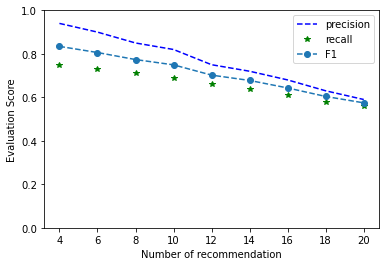

In [31]:
df_evaluation = pd.DataFrame(score, columns=['Precision', 'Recall','F1'],index =Num_rec )
display(df_evaluation)
plt.plot(Num_rec, df_evaluation.iloc[:,0], 'b--', label='precision')
plt.plot(Num_rec, df_evaluation.iloc[:,1], 'g*', label = 'recall')
plt.plot(Num_rec, df_evaluation.iloc[:,2], 'o--', label = 'F1')
plt.xlabel('Number of recommendation')
plt.ylabel('Evaluation Score')
plt.legend(loc='upper right')
plt.ylim([0,1])

## Create content recommender system

In [32]:
def get_recommendation(userid,Top_N, df):
    recommendation = pd.DataFrame(columns = ['userid', 'trackid', 'title', 'score'])
    count = 0
    user_index = np.where(df_user_final['userid']== userid)[0][0]
    user = df_user_final.iloc[[user_index]]
    
    # TF-IDF ( Term Frequency - Inverse Document Frequency )
    user_tfidf_matrix = tfidf_vectorizer.transform(user['text'])
    user_cos_similarity_tfidf = map(lambda x: cosine_similarity(user_tfidf_matrix, x),music_tfidf_matrix)
    output = list(user_cos_similarity_tfidf)
    
    # Function to get the top-N recomendations order by score
    top = sorted(range(len(output)), key=lambda i: output[i], reverse=True)
    list_scores = [output[i][0][0] for i in top]
    for i in top:
        recommendation.at[count, 'userid'] = userid
        recommendation.at[count, 'trackid'] = df['trackid'][i]
        recommendation.at[count, 'title'] = df['title'][i]
        recommendation.at[count, 'score'] =  list_scores[count]
        count += 1
    
    # recommend musics for users that haven't been listened
    u_song_list = df_user[df_user['userid'] == userid]['trackid']
    recommendation = recommendation[~recommendation['trackid'].isin(u_song_list)].dropna()
    recommendation = recommendation[:Top_N].merge(df_meta[['trackid','artistname']], on = 'trackid')[['userid','trackid','artistname','title','score']]
    
    return recommendation

### The top recommendations using TF-IDF

In [33]:
df_user_test = df_user.userid.value_counts().loc[lambda x: x>=8].rename_axis('userid').reset_index(name='counts')
userid = df_user_test.sample(n = 1)['userid'].values[0]
Top_N=8
print('Top ', Top_N,' music recommend for user ',userid)
display(get_recommendation(userid,Top_N,df_meta_all))
print('\n')
print('Music that user ',userid,' has listened')
# check the list that user has listened
u_song_list = df_user[df_user['userid'] == userid].merge(df_meta[['trackid','artistname','title']], on = 'trackid')
display(u_song_list)

Top  8  music recommend for user  ae0764ccd3ca1d49091c06d328495172194179d0


,userid,trackid,artistname,title,score
0,ae0764ccd3ca1d49091c06d328495172194179d0,TREAJBV12903CCDA96,Alicia Keys,Try Sleeping With A Broken Heart,0.316084
1,ae0764ccd3ca1d49091c06d328495172194179d0,TRAFQFV128F9326217,OneRepublic,Good Life,0.305249
2,ae0764ccd3ca1d49091c06d328495172194179d0,TRVFAEW128F42577F3,Phoenix,Too Young,0.293999
3,ae0764ccd3ca1d49091c06d328495172194179d0,TRXEWND128F92C9D0F,Kings Of Leon,Manhattan,0.289088
4,ae0764ccd3ca1d49091c06d328495172194179d0,TRIROYA12903CE1794,Two Door Cinema Club,Something Good Can Work,0.266084
5,ae0764ccd3ca1d49091c06d328495172194179d0,TRHQJCR12903CCDA9F,Usher,Hey Daddy (Daddy's Home),0.2501
6,ae0764ccd3ca1d49091c06d328495172194179d0,TRBKFKL128E078ED76,Eminem,Hailie's Song,0.245997
7,ae0764ccd3ca1d49091c06d328495172194179d0,TRCKWGF12903CD2DCD,Justin Bieber,Never Let You Go,0.244156




Music that user  ae0764ccd3ca1d49091c06d328495172194179d0  has listened


,userid,playcounts,trackid,artistname,title
0,ae0764ccd3ca1d49091c06d328495172194179d0,2,TRRCPXP128E0791F01,Jimmy Eat World,The Middle
1,ae0764ccd3ca1d49091c06d328495172194179d0,1,TRTEGUJ128F425B7D3,Foo Fighters,The Pretender
2,ae0764ccd3ca1d49091c06d328495172194179d0,1,TREMDNV12903CAC420,Black Eyed Peas,I Gotta Feeling
3,ae0764ccd3ca1d49091c06d328495172194179d0,1,TRPGPDK12903CCC651,Evanescence,Bring Me To Life
4,ae0764ccd3ca1d49091c06d328495172194179d0,1,TROMKCG128F9320C09,Muse,Uprising
5,ae0764ccd3ca1d49091c06d328495172194179d0,2,TRSFZUW128F42506D2,The White Stripes,Seven Nation Army
6,ae0764ccd3ca1d49091c06d328495172194179d0,2,TREBDEB12903CC0C56,California Swag District,Teach Me How To Dougie
7,ae0764ccd3ca1d49091c06d328495172194179d0,2,TRYNJBB128F931A7EE,Eminem,Mockingbird


## Recommend for new user

In [176]:
def NewUser(title_list, userid):
    global df_user_final
    text = (' '.join(df_meta_all[(df_meta_all['title'].isin(title_list))]['text']))
    if userid not in df_user_final['userid'].values:
        df_user_final = df_user_final.append({'userid': userid,'text': text},ignore_index=True)
    else:
        text = df_user_final[(df_user_final['userid'] == userid)]['text'].add(text).values
        df_user_final.loc[df_user_final[(df_user_final['userid'] == userid)].index, 'text'] = text
    rec = get_recommendation(userid,8+len(title_list),df_meta_all)
    return rec[~(rec['title'].isin(title_list))].reset_index(drop=True) #, index = True

In [177]:
NewUser(['Never Let You Go','Too Young','Eminem'],'xiaolan')

,userid,trackid,artistname,title,score
0,xiaolan,TRQGEFB12903CCDAA1,Usher,There Goes My Baby,0.33521
1,xiaolan,TREKLEO128F1459433,Tavares,Heaven Must Be Missing An Angel,0.316461
2,xiaolan,TRVYICQ128F4252493,Eric Clapton,Tears In Heaven,0.28977
3,xiaolan,TRKUTLO128F931F1C5,A Day To Remember,Have Faith In Me,0.283531
4,xiaolan,TRFHGWV128E0792EC8,Bryan Adams,Heaven,0.271868
5,xiaolan,TRMOYCC128C7196947,3 Doors Down,Here Without You,0.271682
6,xiaolan,TREAJBV12903CCDA96,Alicia Keys,Try Sleeping With A Broken Heart,0.265403
7,xiaolan,TRCZGBG128F4222F61,Marvin Gaye,Let's Get It On,0.264964
8,xiaolan,TRISZNC12903CA4806,Luke Bryan,Do I,0.263914


In [178]:
print(NewUser(['Never Let You Go','Too Young','Eminem'],'xiaolan')['title'].values)

['There Goes My Baby' 'Heaven Must Be Missing An Angel' 'Tears In Heaven'
 'Have Faith In Me' 'Heaven' 'Here Without You'
 'Try Sleeping With A Broken Heart' "Let's Get It On" 'Do I']


## Collaborative Filtering for Implicit Feedback Datasets

In [38]:
# Load data
df_user = pd.read_csv('music_user.csv', index_col = 0)
df_meta = pd.read_csv('music_meta.csv', index_col = 0)

In [39]:
# Create a numeric user_id and track_id column
data = df_user.copy()
data['userid'] = data['userid'].astype("category")
data['trackid'] = data['trackid'].astype("category")
data['user_id'] = data['userid'].cat.codes # codes are ordered by category letter
data['track_id'] = data['trackid'].cat.codes 

# The implicit library expects data as a item-user matrix so we
# create two matricies, one for fitting the model (item-user) 
# and one for recommendations (user-item)
sparse_item_user = sparse.csr_matrix((data['playcounts'].astype(float), (data['track_id'], data['user_id'])))
sparse_user_item = sparse.csr_matrix((data['playcounts'].astype(float), (data['user_id'], data['track_id'])))

In [52]:
# Initialize the als model and fit it using the sparse item-user matrix
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

# Calculate the confidence by multiplying it by our alpha value. 
alpha_val = 15
data_conf = (sparse_item_user * alpha_val).astype('double')

# Fit the model with confidence weights
model.fit(data_conf)

# Get the user and item vectors from our trained model
user_vecs = model.user_factors
item_vecs = model.item_factors

# Calculate the vector norms
item_norms = np.sqrt((item_vecs * item_vecs).sum(axis=1))

In [43]:
#---------------------
# FIND SIMILAR ITEMS
#---------------------

# Find the 10 most similar to Lambada
track_id = 'TRFZQIW128F93363FC' #Lambada
item_id = int(data[data['trackid']== track_id]['track_id'].values[0])
n_similar = 10

# Calculate the similarity score, grab the top N items and
# create a list of item-score tuples of most similar artists
scores = item_vecs.dot(item_vecs[item_id]) / item_norms
top_idx = np.argpartition(scores, -n_similar)[-n_similar:]
similar = sorted(zip(top_idx, scores[top_idx] / item_norms[item_id]), key=lambda x: -x[1])
top_scores = [i[1]for i in similar]

# Print the names of our most similar track
#for item in similar:
track_list = [data.trackid.loc[data.track_id == item[0]].iloc[0] for item in similar]
df_recommendItems = df_meta[(df_meta['trackid'].isin(track_list))]
# reorder the dataframe by trackid score
true_sort = [s for s in track_list if s in df_recommendItems.trackid.unique()]
df_recommendItems = df_recommendItems.set_index('trackid').loc[true_sort].reset_index()
df_recommendItems['scores'] = top_scores
df_recommendItems

,trackid,artistname,title,lyrics,scores
0,TRFZQIW128F93363FC,Kaoma,Lambada,Chorando se foi quem um dia só me fez chorar C...,1.000000
1,TRXTXMP128EF35F7B9,MIKA,Grace Kelly,"""The last time we talked, Mr. Smith You reduce...",0.780252
2,TREWPDP128E07896EE,Black Eyed Peas,Pump It,Hut hut haaaa Pump it Hut hut haaaa And pump i...,0.611178
3,TRKQHRE128F4257BA6,Shaggy,Boombastic,Mr. Boombastic. What you want is some boombast...,0.562088
4,TRVTKOU128E078E0DA,Alanis Morissette,Ironic (Acoustic Album Version),An old man turned ninety-eight He won the lott...,0.553638
5,TRLABJZ128F42A0DD7,Natalie Imbruglia,Torn,I thought I saw a man brought to life He was w...,0.540227
6,TRTSQLA12903D0737C,John Waite,Missing You,Every time I think of you I always catch my br...,0.531552
7,TRBIXDZ128F427E461,Tears For Fears,Everybody Wants To Rule The World,Welcome to your life There's no turning back E...,0.527130
8,TRYFTOL128F92FDA1A,Natasha Bedingfield,Unwritten,I am unwritten Can't read my mind I'm undefine...,0.505060
9,TROUKLP12903CB6364,Vampire Weekend,White Sky,"An ancient business, a modern piece of glasswo...",0.502196


In [44]:
#------------------------------
# CREATE USER RECOMMENDATIONS
#------------------------------

def recommend(user_id, sparse_user_item, user_vecs, item_vecs, num_items=10):
    """The same recommendation function we used before"""

    user_interactions = sparse_user_item[user_id,:].toarray()

    user_interactions = user_interactions.reshape(-1) + 1
    user_interactions[user_interactions > 1] = 0

    rec_vector = user_vecs[user_id,:].dot(item_vecs.T).toarray()

    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    recommend_vector = user_interactions * rec_vector_scaled

    item_idx = np.argsort(recommend_vector)[::-1][:num_items]

    tracks = []
    scores = []

    for idx in item_idx:
        tracks.append(data.trackid.loc[data.track_id == idx].iloc[0])
        scores.append(recommend_vector[idx])

    recommendations = pd.DataFrame({'trackid': tracks, 'score': scores})

    return recommendations

# Get the trained user and item vectors. We convert them to 
# csr matrices to work with our previous recommend function.
user_vecs = sparse.csr_matrix(model.user_factors)
item_vecs = sparse.csr_matrix(model.item_factors)

# Create recommendations for user with id
userid = 'ae0764ccd3ca1d49091c06d328495172194179d0'
user_id = int(data[data['userid']== userid]['user_id'].values[0])
recommendations = recommend(user_id, sparse_user_item, user_vecs, item_vecs)

recommendations = recommendations.merge(df_meta[['trackid','artistname','title']], on = 'trackid')[['trackid','artistname','title','score']]
recommendations

,trackid,artistname,title,score
0,TRRNFHH128F92D262D,Rise Against,Savior,1.000000
1,TRSUSWW128F93463BF,Black Eyed Peas,Imma Be,0.955454
2,TRBZGSM128E078EDB4,Eminem,Without Me,0.881518
3,TRRUVLO128F92DE6F7,La Roux,Bulletproof,0.861572
4,TREWTIO128F145497E,Eminem,The Real Slim Shady,0.855507
5,TRCWHIO128F1488FB7,Daft Punk,Harder Better Faster Stronger,0.821839
6,TRLRGVX128E078EC1B,Eminem,My Name Is,0.814968
7,TRHTCXG12903CC2F60,3 Doors Down,Kryptonite,0.748263
8,TRBKFKL128E078ED76,Eminem,Hailie's Song,0.744746
9,TREBUCN128F92D2CAC,MGMT,Electric Feel,0.743690


In [45]:
# check the list that user has listened
u_song_list = df_user[df_user['userid'] == userid].merge(df_meta[['trackid','artistname','title']], on = 'trackid')
display(u_song_list)

,userid,playcounts,trackid,artistname,title
0,ae0764ccd3ca1d49091c06d328495172194179d0,2,TRRCPXP128E0791F01,Jimmy Eat World,The Middle
1,ae0764ccd3ca1d49091c06d328495172194179d0,1,TRTEGUJ128F425B7D3,Foo Fighters,The Pretender
2,ae0764ccd3ca1d49091c06d328495172194179d0,1,TREMDNV12903CAC420,Black Eyed Peas,I Gotta Feeling
3,ae0764ccd3ca1d49091c06d328495172194179d0,1,TRPGPDK12903CCC651,Evanescence,Bring Me To Life
4,ae0764ccd3ca1d49091c06d328495172194179d0,1,TROMKCG128F9320C09,Muse,Uprising
5,ae0764ccd3ca1d49091c06d328495172194179d0,2,TRSFZUW128F42506D2,The White Stripes,Seven Nation Army
6,ae0764ccd3ca1d49091c06d328495172194179d0,2,TREBDEB12903CC0C56,California Swag District,Teach Me How To Dougie
7,ae0764ccd3ca1d49091c06d328495172194179d0,2,TRYNJBB128F931A7EE,Eminem,Mockingbird
